In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2 
from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import pandahouse as ph

# 1.1

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### Предварительный анализ данных

In [2]:
groups = pd.read_csv('groups.csv', sep = ';')

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
# Пропущенные значения отсутствуют, тип данных верный, в других таблицах аналогично
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
groups.nunique()

id     74484
grp        2
dtype: int64

In [6]:
group_add = pd.read_csv('group_add.csv', sep = ',')

In [7]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [8]:
group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [9]:
active = pd.read_csv('active_studs.csv')

In [10]:
active.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [11]:
active.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [12]:
active.nunique()

student_id    8341
dtype: int64

In [13]:
checks = pd.read_csv('checks.csv', sep = ';')

In [14]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [15]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [16]:
# в таблице checks все пользователи уникальны, т.е. каждый пользователь совершил одну покупку
checks.nunique()

student_id    541
rev            39
dtype: int64

In [17]:
# переименуем колонку
groups.rename(columns = {'id': 'student_id'}, inplace=True)

In [18]:
active_student = active.student_id
checks.query('student_id not in @active_student').shape[0]

149

149 пользователей совершили покупку, но не были в таблице активных за этот период пользователей.
Необходимо выяснить, почему могло так произойти, возможно, была автоматическая оплата, зависли платежи или это ошибка.

В рамках данного анализа мы не берем этих пользователей, так как они могли не видеть новый способ оплаты.

### Метрики
В ходе анализа мы будем рассматривать следующие метрики:

- CR в покупку

Новый механика оплаты могла положительно повлиять на конверсию в покупку. Возможно оплата стала более быстрой, удобной для пользователей, или убрали шаги, на которых пользователи прекращали покупку.

- Средний чек

При этом стоит проанализировать денежную метрику - средний чек, посмотреть не просела ли данная метрика.

### Конверсия

Для определения стат значимых различий конверсии в покупку будем использовать хи-квадрат (взаимодействие оплатил/не оплатил и группы)

In [19]:
# Соединяем наши таблицы так, чтобы увидеть, какие из активных пользователей сделали покупку, а какие нет 
total_df = active.merge(groups, on = 'student_id').merge(checks, on = 'student_id', how = 'left')
total_df

,student_id,grp,rev
0,581585,A,NaN
1,3276743,B,NaN
2,4238589,A,NaN
3,4475369,B,NaN
4,5481015,B,NaN
...,...,...,...
8323,1794344,B,NaN
8324,296883,B,NaN
8325,3598448,B,NaN
8326,3610547,B,290.0


In [20]:
# считаем количество покупок и активных пользователей
conversion = total_df.groupby('grp', as_index=False).agg(purchases=('rev', 'count'), all_st=('rev', 'size'))
conversion

,grp,purchases,all_st
0,A,78,1535
1,B,313,6793


In [21]:
# рассчитываем конверсию
conversion['CR'] = (conversion.purchases / conversion.all_st * 100).round(2)
conversion[['grp', 'CR']]

,grp,CR
0,A,5.08
1,B,4.61


In [22]:
np.round(conversion.CR.loc[0] - conversion.CR.loc[1], 2)

0.47

Конверсия в покупку в тестовой группе уменьшилась на 0.47 п.п.


Проверим, является ли этот результат стат значимым с помощью Хи-квадрат

H0: взаимосвязи между двумя переменными (оплата и группа) нет

H1: взаимосвязь между двумя переменными (оплата и группа) есть

In [23]:
# добавляем метку оплатили/не оплатили
total_df['payment'] = np.where(total_df['rev'].notnull(),'yes', 'no')

In [24]:
# рассчитывает количество пользователей оплативших и не оплативших для каждой группы
for_hi = pd.crosstab(total_df.grp, total_df.payment)
for_hi

payment,no,yes
grp,,
A,1457,78
B,6480,313


In [25]:
# Применяем Хи-квадрат
stat, p, dof, expected = chi2_contingency(for_hi)

In [26]:
stat, p

(0.526607176998989, 0.46803677583199144)

In [27]:
alpha = 0.05
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Вывод по конверсии

Конверсия в покупку в тестовой группе уменьшилась на 9%, но результат не является статистически значимым. Однако это значительное снижение конверсии. Посмотрим на средний чек, чтобы понять, внедрять ли новый способ оплаты

### Средний чек

In [28]:
# оставляем только тех пользователей, которые были активны и совершили покупку
metric_check = total_df[total_df['rev'].notnull()]
metric_check.head()

,student_id,grp,rev,payment
61,1184303,A,1530.0000,yes
66,3354191,B,1900.0001,yes
76,3278734,B,1900.0000,yes
98,720651,A,1980.0000,yes
191,1232221,B,1900.0000,yes


In [29]:
# значения чеков в контрольной группе
control = metric_check[metric_check.grp == 'A'].rev
# значения чеков в тестовой группе
test = metric_check[metric_check.grp == 'B'].rev

In [30]:
# средний чек
avg_check = metric_check.groupby('grp', as_index=False).rev.mean().round(2).rename(columns={'rev': 'avg_check'})
avg_check

,grp,avg_check
0,A,933.59
1,B,1255.83


In [31]:
# описательная статистика контрольной группы
control.describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [32]:
# описательная статистика тестовой группы
test.describe()

count     313.000000
mean     1255.827487
std       791.293377
min       199.000000
25%       489.000000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [33]:
test.mean() - control.mean()

322.23774363070436

Количество пользователей в контрольной и тестовой группах значительно отличаются

Средний чек увеличился на 322 у.е.

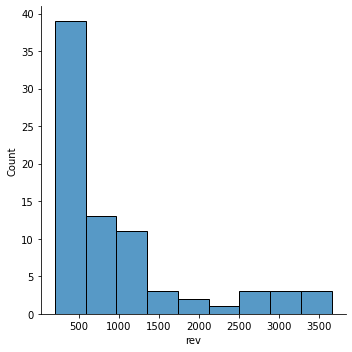

In [34]:
# По графикам распределения отличаются от нормального. Проверим с помощью теста
sns.displot(control)

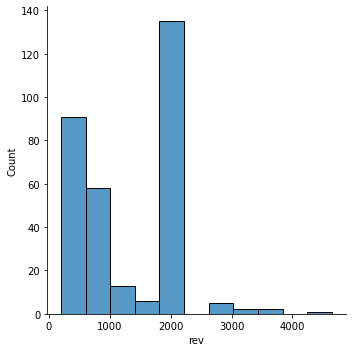

In [35]:
sns.displot(test)

In [36]:
# обратим внимание, что в тестовой группе появилось большое количество чеков с одинаковой суммой 1900. 
# Необходимо выяснить причину, возможно, была акция, или это ошибка
test.value_counts().head()

1900.0000    92
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
Name: rev, dtype: int64

In [37]:
# Тест Шапиро-Уилка показал, что p < 0.05. Значит, распределения в тестовой и контрольной группах отличаются от нормального
ss.shapiro(control)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

In [38]:
ss.shapiro(test)

ShapiroResult(statistic=0.8551987409591675, pvalue=1.756778758085431e-16)

In [39]:
# дисперсии не различаются
ss.levene(control, test)

LeveneResult(statistic=3.055864350672603, pvalue=0.08123509393501775)

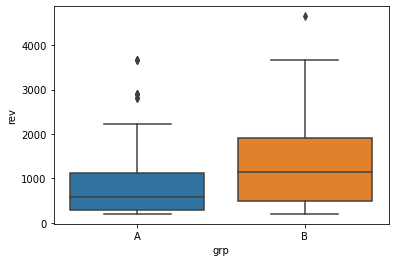

In [40]:
# Посмотрим выбросы. Выбросы в группах есть, это могут быть крупные заказчики
ax = sns.boxplot(x="grp", y="rev", data=metric_check)

### Выбор статистического критерия

Промежуточные итоги:
- Количество пользователей в группах различаются (снижается мощность стат критериев). 
- Распределения в группах отличаются от нормального. 
- Присутствуют выбросы. 

Эти пункты не явлются прямым запретом на использование t-критерия Стьюдента, но из-за них снижается мощность критерия и возрастает вероятность совершить ошибку.

Будем использовать bootstrap для среднего

In [41]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

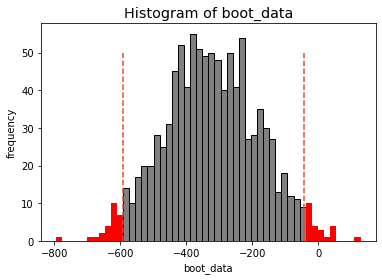

In [42]:
booted_data = get_bootstrap(control, test)

In [43]:
booted_data["p_value"] # альфа

0.021925178670100798

In [44]:
booted_data["quants"] # ДИ

,0
0.025,-592.872769
0.975,-44.374373


p value < 0.05, доверительный интервал не содержит 0, отклоняем нулевую гипотезу о равенстве средних. 

Средний чек в целевой группе стат значимо увеличился

### Общая таблица с метриками

In [45]:
metrics = conversion.merge(avg_check, on='grp')[['grp', 'CR', 'avg_check']]
metrics

,grp,CR,avg_check
0,A,5.08,933.59
1,B,4.61,1255.83


In [46]:
# мы можем рассчитать общую метрику ARPU, учитывающую конверсию и средний чек
metrics['ARPU'] = round(metrics.CR / 100 * metrics.avg_check, 2)
metrics

,grp,CR,avg_check,ARPU
0,A,5.08,933.59,47.43
1,B,4.61,1255.83,57.89


## Вывод:

Средний чек в целевой группе статистически значимо отличается от контрольной группы. Он увеличился на 322 у.е. 

При этом конверсия в покупку снизилась в целевой группе, но мы не можем утверждать, что конверсия ухудшилась (мы не отклонили
нулевую гипотезу). Конверсия является важным показателем, поэтому необходимо доп исследование.

На основе этого делаем вывод, что новую механику оплаты можно запускать на всех пользователей, если при дополнительном исследовании конверсии показатель не ухудшится.

# Задание 2. SQL

2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.
NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.
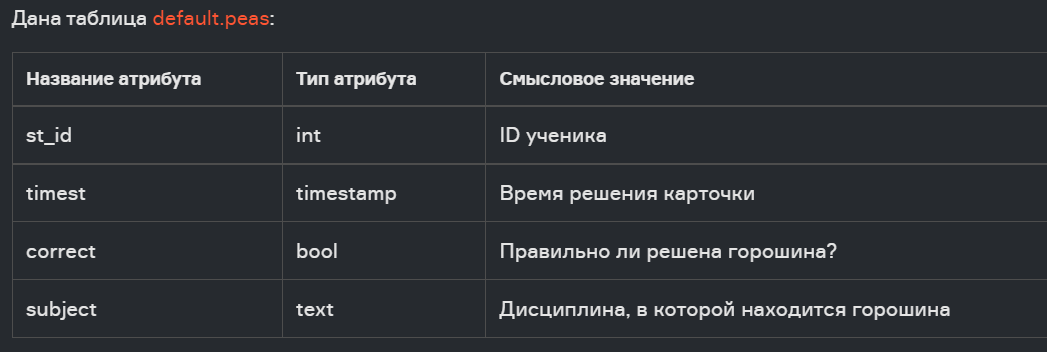

In [47]:
query = """
SELECT COUNT(st_id) AS stud_count

FROM (

SELECT 
    st_id,
    COUNT(correct) AS success_task
FROM default.peas
WHERE toStartOfMonth(timest) = '2020-03-01'
GROUP BY st_id
HAVING success_task >= 20
)
"""

2.2 Оптимизация воронки

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU, 
ARPAU,
CR в покупку,
СR активного пользователя в покупку, 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике.
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

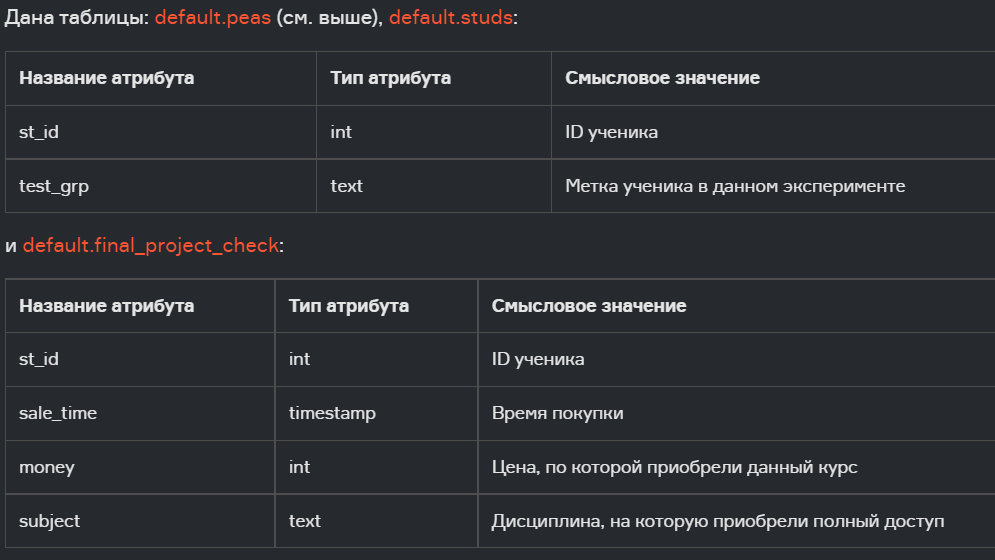

In [48]:
query = """
WITH peas_st AS (                          -- количество успешных задач по каждому студенту
    SELECT 
        st_id,
        COUNT(correct) AS success_task
    FROM default.peas
    GROUP BY st_id
),

active_math AS (                           -- студенты, активные по математике
    SELECT 
        st_id,
        COUNT(correct) AS math_task,
        1 AS st_active_math
    FROM default.peas
    WHERE subject == 'Math'
    GROUP BY st_id
    HAVING math_task >= 2
),

purchases_math AS (                        -- студенты, купившие курс по математике
    SELECT 
        st_id,
        1 AS purchases_math
    FROM final_project_check
    WHERE subject == 'Math' 
    AND st_id IN 
        (SELECT st_id 
        FROM active_math)
),

checks AS (                                -- сумма покупок по каждому студенту
    SELECT 
        st_id,
        SUM(money) AS money
    FROM final_project_check
    GROUP BY st_id
)


SELECT                                      -- расчет метрик
    test_grp,
    SUM(money) / COUNT(st_id) AS ARPU,
    SUM(money) / countIf(st_id, success_task > 10) AS ARPAU,
    countIf(st_id, money > 0) / COUNT(st_id) * 100 AS CR,
    countIf(st_id, success_task > 10 and money > 0) / countIf(st_id, success_task > 10) * 100 AS CR_active,
    countIf(st_id, purchases_math = 1 and success_task > 10 and money > 0) / countIf(st_id, st_active_math = 1) * 100 AS CR_math


FROM (                                      -- соединение всех таблиц

    SELECT studs.st_id AS st_id,
    peas_st.success_task AS success_task,
    studs.test_grp AS test_grp,
    active_math.st_active_math AS st_active_math,
    purchases_math.purchases_math AS purchases_math,
    c.money AS money

    FROM studs 
    LEFT JOIN peas_st s
    ON studs.st_id = s.st_id
    LEFT JOIN active_math
    ON s.st_id = active_math.st_id
    LEFT JOIN purchases_math
    ON s.st_id = purchases_math.st_id
    LEFT JOIN checks c
    ON s.st_id = c.st_id
)

GROUP BY test_grp
"""

# Задание 3. Python
3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [49]:
# Функция пересчета метрик с доп файлом
def metrics_new_add(file_path, total_df):
    group_add = pd.read_csv(file_path, sep = ',')
    group_add.rename(columns = {group_add.columns[0]: 'student_id', group_add.columns[1]: 'grp'}, inplace=True)
    group_add = active.merge(group_add, on = 'student_id').merge(checks, on = 'student_id', how = 'left')
    add_total_df = pd.concat([total_df, group_add]) # объединяем старую и новую таблицы
    conversion_add = add_total_df.groupby('grp', as_index=False).agg(purchases=('rev', 'count'), all_st=('rev', 'size'))
    conversion_add['CR'] = (conversion_add.purchases / conversion_add.all_st * 100).round(2)
    avg_check_add = add_total_df[add_total_df['rev'].notnull()] \
                    .groupby('grp', as_index=False).rev.mean().round(2) \
                    .rename(columns={'rev': 'avg_check'})
    metrics_add = conversion_add.merge(avg_check_add, on='grp')[['grp', 'CR', 'avg_check']]
    metrics_add['ARPU'] = round(metrics_add.CR / 100 * metrics_add.avg_check, 2)

    return metrics_add

In [50]:
# метрики после добавления файла
metrics_new = metrics_new_add('group_add.csv', total_df)
metrics_new

,grp,CR,avg_check,ARPU
0,A,5.07,933.59,47.33
1,B,4.62,1257.88,58.11


Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [51]:
# Функция визуализации метрик
def get_vizualisation(metrics):
    sns.set(font_scale = 1.5, style='whitegrid')
    fig, axs = plt.subplots(1, 3, figsize=(15,6))
    ax = sns.barplot(x='grp', y='ARPU', data=metrics, ax=axs[0])
    ax.set_xlabel('Group')
    ax.set_ylabel('ARPU')
    ax.set_title('ARPU by groups\n')
    ax = sns.barplot(x='grp', y='CR', data=metrics, ax=axs[1])
    ax.set_xlabel('Group')
    ax.set_ylabel('Conversion rate, %')
    ax.set_title('Conversion rate by groups\n')
    ax = sns.barplot(x='grp', y='avg_check', data=metrics, ax=axs[2])
    ax.set_xlabel('Group')
    ax.set_ylabel('Average check')
    ax.set_title('Average check by groups\n')
    sns.despine()
    plt.subplots_adjust(wspace=0.5)

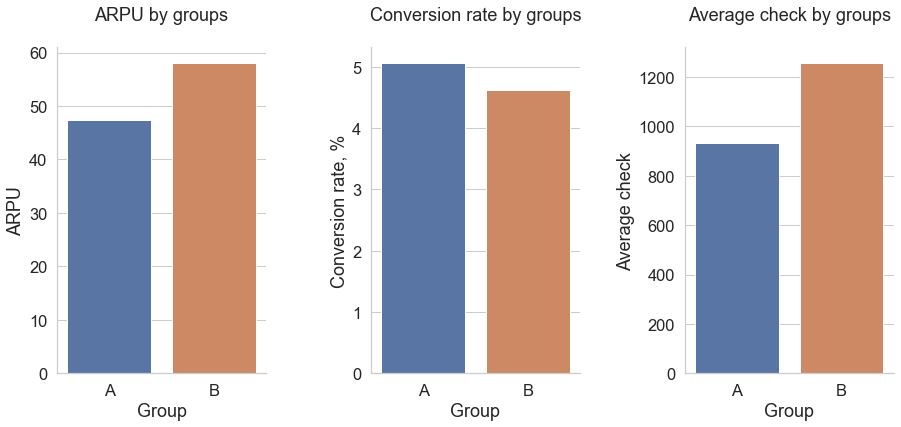

In [52]:
get_vizualisation(metrics_new)